            Date        Open        High         Low       Close   Adj Close  \
0     2009-04-20   13.040000   13.040000   12.640000   12.780000   11.706666   
1     2009-04-21   12.875400   12.890000   12.100000   12.820000   11.743308   
2     2009-04-22   12.900000   13.280000   12.260000   12.640000   11.578426   
3     2009-04-23   12.760000   13.000000   12.570000   12.940000   11.853230   
4     2009-04-24   13.200000   13.200000   12.850000   13.190000   12.082233   
5     2009-04-27   13.000000   13.220000   12.700000   13.070000   11.972313   
6     2009-04-28   13.040000   13.500000   12.800000   13.030000   11.935671   
7     2009-04-29   12.900000   13.430000   12.900000   13.380000   12.256277   
8     2009-04-30   13.600000   14.000000   13.540000   13.800000   12.641003   
9     2009-05-04   14.120000   15.000000   14.020000   14.840000   13.593657   
10    2009-05-05   14.840000   15.000000   14.540000   14.760000   13.520375   
11    2009-05-06   14.260000   14.800000

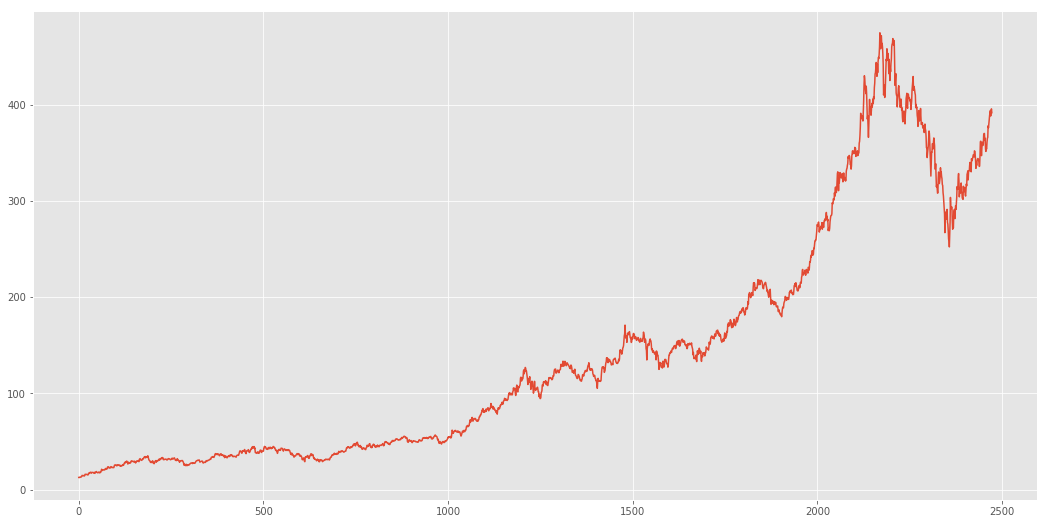

In [87]:
# https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru/notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
from keras import backend as K
import random, os, sys
import tensorflow as tf

import math
import sklearn
import sklearn.preprocessing

style.use('ggplot')

valid_set_size_percentage = 10 
test_set_size_percentage = 10 

 
#read the file
df = pd.read_csv('dataset/daily_0700.HK.csv')
df = df.dropna()

training_set = df.iloc[:, 4:5].values

print(df)
print(training_set)

# print(len(df.index))

SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

#plot
plt.figure(figsize=(18,9))
plt.plot(df[RATIO_TO_PREDICT], label='Close Price history')

In [35]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [36]:
df.drop(['Adj Close','Volume'],1,inplace=True)
df_stock_norm = df
df_stock_norm = normalize_data(df_stock_norm)

In [43]:
df_stock_norm
cols = list(df_stock_norm.columns.values)
print('df_stock.columns.values = ', cols)
seq_len = 20 # choose sequence length
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(df_stock_norm, seq_len)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_valid.shape = ',X_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['Date', 'Open', 'High', 'Low', 'Close']
X_train.shape =  (1961, 19, 5)
y_train.shape =  (1961, 5)
X_valid.shape =  (245, 19, 5)
y_valid.shape =  (245, 5)
X_test.shape =  (245, 19, 5)
y_test.shape =  (245, 5)


/Users/ShInGSon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


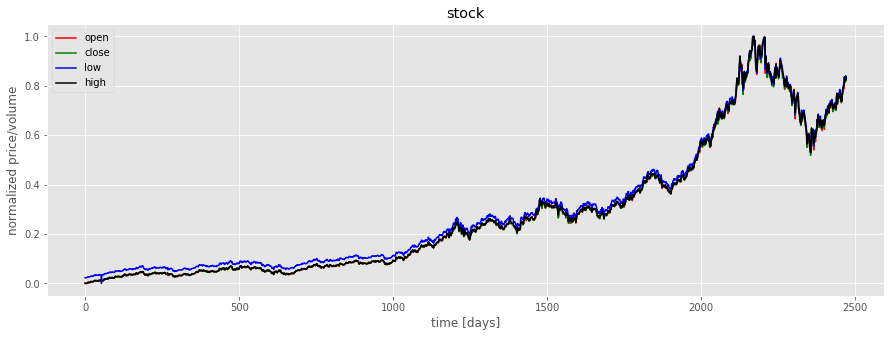

In [44]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.Open.values, color='red', label='open')
plt.plot(df_stock_norm.Close.values, color='green', label='close')
plt.plot(df_stock_norm.Low.values, color='blue', label='low')
plt.plot(df_stock_norm.High.values, color='black', label='high')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [82]:
X_train = X_train[:,:,4]
# X_train.shape[0]
# print(X_train)

[[0.00030305653775578034 0.0003896441199717181 0.0 ...
  0.004156203946365001 0.007251710010584767 0.007078534846152892]
 [0.0003896441199717181 0.0 0.0006494068666195278 ...
  0.007251710010584767 0.007078534846152892 0.007489825861678599]
 [0.0 0.0006494068666195278 0.0011905792554691395 ...
  0.007078534846152892 0.007489825861678599 0.007013594159490943]
 ...
 [0.46791930078899513 0.4601264054014235 0.45536409487361557 ...
  0.471815748482781 0.46618754265060774 0.4709498531784157]
 [0.4601264054014235 0.45536409487361557 0.4601264054014235 ...
  0.46618754265060774 0.4709498531784157 0.4848038858151717]
 [0.45536409487361557 0.4601264054014235 0.45926054256740134 ...
  0.4709498531784157 0.4848038858151717 0.48437092192781733]]


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [46]:
regressor = Sequential()

In [83]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

ValueError: Input 0 of layer unified_lstm_4 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1]